In [1]:
from dotenv import load_dotenv
load_dotenv()#'../.env')

False

In [4]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [6]:
from langchain_groq.chat_models import ChatGroq
llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

In [7]:
llm.invoke("what's the weather in sf?")

AIMessage(content="I'm not able to provide real-time weather information. However, I can give you general information about San Francisco's climate.\n\nSan Francisco is known for its cool and foggy climate, with temperatures ranging from 40°F (4°C) to 70°F (21°C) throughout the year. The city experiences a Mediterranean climate, with dry summers and wet winters.\n\nIf you're looking for the current weather in San Francisco, I recommend checking a weather website or app, such as AccuWeather or Weather.com, for the most up-to-date information.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 42, 'total_tokens': 155, 'completion_time': 0.452778016, 'prompt_time': 0.015188738, 'queue_time': 2.4164770410000003, 'total_time': 0.467966754}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-93446453-99ef-46fb-9d14-5c5879e2eca1-0', usage_metadata={'input_tokens'

In [8]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"

In [9]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [11]:
llm_with_toolcall = llm.bind_tools(tools=tools)

In [12]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_toolcall.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

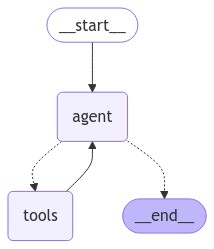

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
content='' additional_kwargs={'tool_calls': [{'id': 'call_5b4h', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 267, 'total_tokens': 282, 'completion_time': 0.06, 'prompt_time': 0.076024615, 'queue_time': 0.070458021, 'total_time': 0.136024615}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b3ae7e594e', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-dd106019-07a5-463b-a8e8-4403ae996ca2-0' tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_5b4h', 'type': 'tool_call'}] usage_metadata={'input_tokens': 267, 'output_tokens': 15, 'total_tokens': 282}
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_5b4h)
 Call ID: call_5b4h


In [15]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
content='' additional_kwargs={'tool_calls': [{'id': 'call_jvfm', 'function': {'arguments': '{}', 'name': 'get_coolest_cities'}, 'type': 'function'}, {'id': 'call_65kq', 'function': {'arguments': '{"location": "coolest_cities[0]"}', 'name': 'get_weather'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 269, 'total_tokens': 298, 'completion_time': 0.116104024, 'prompt_time': 0.066922202, 'queue_time': 0.005387921000000004, 'total_time': 0.183026226}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-2437aad1-8f64-454d-abda-22717dfbcc9e-0' tool_calls=[{'name': 'get_coolest_cities', 'args': {}, 'id': 'call_jvfm', 'type': 'tool_call'}, {'name': 'get_weather', 'args': {'location': 'coolest_cities[0]'}, 'id': 'call_65kq', 'type': 'too